In [ ]:
!pip install pyDOE

In [ ]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt

import imageio
import os
from google.colab import files

In [ ]:
# For reproducability
tf.random.set_seed(1234)
np.random.seed(1234)

In [ ]:
u0 = lambda x: -np.sin(np.pi*x)
c = 1.0

In [ ]:
# Boundaries of the computational domain
xleft, xright = -1, 1
t0, tfinal = 0, 3.0

Text(0, 0.5, 'u')

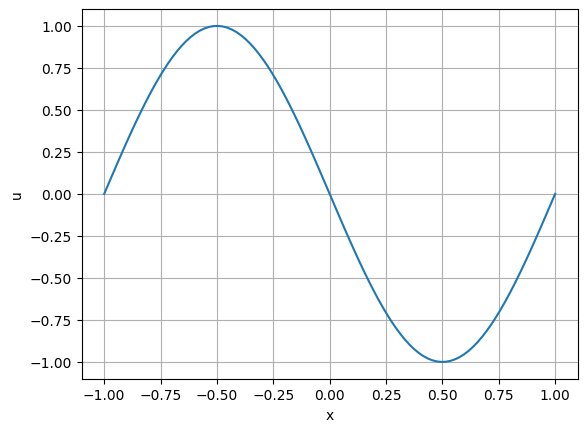

In [ ]:
# Plot initial solution
x = np.linspace(xleft, xright, 100)
plt.plot(x, u0(x))
plt.grid()
plt.xlabel('x')
plt.ylabel('u')

### Define the network

In [ ]:
# Define the network
def build_neural_network(n_layers = 6, n_units = 20, summary = False):

  inp1 = tf.keras.layers.Input(shape=(1,))
  b1 = tf.keras.layers.Lambda(lambda x: 2.0*(x - t0)/(tfinal-t0)-1.0)(inp1)

  # Make input periodic
  inp2 = tf.keras.layers.Input(shape=(1,))
  b2 = tf.keras.layers.Lambda(lambda x: tf.concat((tf.cos(np.pi*x),
                                                   tf.sin(np.pi*x)), axis=1))(inp2)

  b = tf.keras.layers.Concatenate()([b1, b2])

  for i in range(n_layers):
    b = tf.keras.layers.Dense(n_units, activation='tanh')(b)
  out = tf.keras.layers.Dense(1, activation='linear')(b)

  model = tf.keras.models.Model([inp1, inp2], out)

  if summary:
    model.summary()

  return model

### Common functions

In [ ]:
# Generate the collocation points for the PINN model
def generate_dataset(data, N_pde, N_iv, bs_pdes, bs_inits):

  # Extract the parameters of the model
  t_bdry = data['t_bdry']
  x_bdry = data['x_bdry']
  u0 = data['u0']

  # Sample points where to evaluate the PDE
  tx_min = np.array([t_bdry[0], x_bdry[0]])
  tx_max = np.array([t_bdry[1], x_bdry[1]])
  pde_points = tx_min + (tx_max - tx_min)*lhs(2, N_pde)
  t_pde = pde_points[:,0]
  x_pde = pde_points[:,1]
  pdes = np.column_stack([t_pde, x_pde]).astype(np.float32)

  # Sample points where to evaluate the initial values
  init_points = tx_min[1:] + (tx_max[1:] - tx_min[1:])*lhs(1, N_iv)
  x_init = init_points
  t_init = t_bdry[0]+ 0.0*x_init
  u_init = u0(x_init)
  inits = np.column_stack([t_init, x_init, u_init]).astype(np.float32)

  ds_pde = tf.data.Dataset.from_tensor_slices(pdes)
  ds_pde = ds_pde.cache().shuffle(N_pde).batch(bs_pdes)

  ds_init = tf.data.Dataset.from_tensor_slices(inits)
  ds_init = ds_init.cache().shuffle(N_iv).batch(bs_inits)

  ds = tf.data.Dataset.zip((ds_pde, ds_init))
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [ ]:
# Convert the ragged tensors that make up a model into a one-dimensional vector
def reshape_to_vector(vars):
  vars_vector = tf.concat([tf.reshape(p, [-1]) for p in vars], axis=0)
  return vars_vector

In [ ]:
# This updates the weights of a given model as ragged tensor from the weights
# collected in a one-dimensional weight vector
def reshape_to_model(vars, model):

  k = 0

  for (i, curr_layer) in enumerate(model.layers):
    weights_and_biases = curr_layer.get_weights()

    # Check if the layer actually has weights and then set them
    if len(weights_and_biases) > 1:
      new_weights_and_biases = []
      for l in range(len(weights_and_biases)):
        shape_weights = tf.shape(weights_and_biases[l])
        no_weights = tf.reduce_prod(shape_weights)
        new_weights_and_biases.append(tf.reshape(vars[k:k+no_weights], shape_weights))
        k += no_weights

      # Now set the new weights
      model.layers[i].set_weights(new_weights_and_biases)

In [ ]:
def standardize_tensor(vars, ep = 1e-5):
  return vars/tf.sqrt(tf.reduce_mean(tf.square(vars) + ep, axis=0))

In [ ]:
@tf.function
def train_step_learn(pdes, inits, model, c=1):

  t_pde, x_pde = pdes[:,:1], pdes[:,1:2]
  t_init, x_init, u_init = inits[:,:1], inits[:,1:2], inits[:,2:3]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape() as tape1:
      tape1.watch(t_pde), tape1.watch(x_pde)
      u = model([t_pde, x_pde])
    [ut, ux] = tape1.gradient(u, [t_pde, x_pde])

    # Solve Burgers equations
    eqn = ut + c*ux

    # Define the PDE loss
    PDEloss = tf.reduce_mean(tf.square(eqn))

    # Define the initial value loss
    u_init_pred = model([t_init, x_init])
    IVloss = tf.reduce_mean(tf.square(u_init-u_init_pred))

    # Global loss
    loss = PDEloss + IVloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return PDEloss, IVloss, grads

In [ ]:
@tf.function
def train_step_burgers(pdes, inits, model, c=-0.01/np.pi):

  t_pde, x_pde = pdes[:,:1], pdes[:,1:2]
  t_init, x_init, u_init = inits[:,:1], inits[:,1:2], inits[:,2:3]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape() as tape1:
      tape1.watch(t_pde), tape1.watch(x_pde)
      with tf.GradientTape() as tape2:
        tape2.watch(t_pde), tape2.watch(x_pde)
        u = model([t_pde, x_pde])
      [ut, ux] = tape2.gradient(u, [t_pde, x_pde])
    uxx = tape1.gradient(ux, x_pde)

    # Solve Burgers equations
    eqn = ut + u*ux + c*uxx

    # Define the PDE loss
    PDEloss = tf.reduce_mean(tf.square(eqn))

    # Define the initial value loss
    u_init_pred = model([t_init, x_init])
    IVloss = tf.reduce_mean(tf.square(u_init-u_init_pred))

    # Global loss
    loss = PDEloss + IVloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return PDEloss, IVloss, grads

In [ ]:
@tf.function
def train_step_kdv(pdes, inits, model, c=-0.0025):

  t_pde, x_pde = pdes[:,:1], pdes[:,1:2]
  t_init, x_init, u_init = inits[:,:1], inits[:,1:2], inits[:,2:3]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape() as tape1:
      tape1.watch(t_pde), tape1.watch(x_pde)
      with tf.GradientTape() as tape2:
        tape2.watch(t_pde), tape2.watch(x_pde)
        with tf.GradientTape() as tape3:
          tape3.watch(t_pde), tape3.watch(x_pde)
          u = model([t_pde, x_pde])
        [ut, ux] = tape3.gradient(u, [t_pde, x_pde])
      uxx = tape2.gradient(ux, x_pde)
    uxxx = tape1.gradient(uxx, x_pde)

    # Solve the KdV equations
    eqn = ut+u*ux-c*uxxx

    # Define the PDE loss
    PDEloss = tf.reduce_mean(tf.square(eqn))

    # Define the initial value loss
    u_init_pred = model([t_init, x_init])
    IVloss = tf.reduce_mean(tf.square(u_init-u_init_pred))

    # Global loss
    loss = PDEloss + IVloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return PDEloss, IVloss, grads

In [ ]:
@tf.function
def train_step_poisson(pdes, bcs):

  x_pde, y_pde = pdes[:,:1], pdes[:,1:2]
  x_bc, y_bc, u_bc = bcs[:,:1], bcs[:,1:2], bcs[:,2:3]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    # # Inner gradient for derivatives of u wrt x and t
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(x_pde), tape1.watch(y_pde)
      with tf.GradientTape() as tape2:
        tape2.watch(x_pde), tape2.watch(y_pde)
        u = model([x_pde, y_pde])
      [ux, uy] = tape2.gradient(u, [x_pde, y_pde])
    uxx = tape1.gradient(ux, x_pde)
    uyy = tape1.gradient(uy, y_pde)

    # Solve the KdV equations
    eqn = uxx + uyy - f(x_pde, y_pde)

    # Define the PDE loss
    PDEloss = tf.reduce_mean(tf.square(eqn))

    # Define the boundary value loss
    u_bc_pred = model([x_bc, y_bc])
    BCloss = tf.reduce_mean(tf.square(u_bc-u_bc_pred))

    # Global loss
    loss = PDEloss + BCloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_variables)

  return PDEloss, BCloss, grads

### Adam optimizer

In [ ]:
class AdamOptimizer():
  def __init__(self, learning_rate=2e-4, beta_1=0.9, beta_2=0.999, ep=1e-5):

    self.learning_rate = learning_rate
    self.beta_1 = beta_1
    self.beta_2 = beta_2
    self.ep = ep

    self.built = False
    self.steps = 0


  # Standard Adam
  def apply_gradients(self, vars, grads):

    # Reshape the weights and gradients into a vector
    vars_vector = reshape_to_vector(vars)
    grads_vector = reshape_to_vector(grads)

    # Add the momentum and velocity vectors
    if not self.built:

      self.momentum = tf.zeros(tf.shape(vars_vector))
      self.velocity = tf.zeros(tf.shape(vars_vector))
      self.built = True

    # Update step counter
    self.steps += 1

    # Adam update rule
    self.momentum = self.beta_1*self.momentum + (1-self.beta_1)*grads_vector
    self.velocity = self.beta_2*self.velocity + (1-self.beta_2)*tf.square(grads_vector)

    momentum_corr = self.momentum/(1-self.beta_1**self.steps)
    velocity_corr = self.velocity/(1-self.beta_2**self.steps)

    # Blackbox update
    adam_update = self.learning_rate*momentum_corr/tf.sqrt(velocity_corr + self.ep)

    # Update the weights
    vars_vector -= adam_update

    return vars_vector


  # Train a model using our Adam optimizer
  def train_model(self, data, model, eqn='la', epochs=5000, N_pde=10000, N_iv=100):

    # Generate the training dataset
    ds = generate_dataset(data, N_pde, N_iv, N_pde//10, N_iv//10)

    # Epoch loss initialization
    epoch_loss = np.zeros(epochs)

    # Main training loop
    for i in range(epochs):

      n_batches = 0
      for (pdes, inits) in ds:

        # Gradient step
        if eqn == 'la':
          PDEloss, IVloss, grads = train_step_learn(pdes, inits, model)
        elif eqn == 'kdv':
          PDEloss, IVloss, grads = train_step_kdv(pdes, inits, model)
        elif eqn == 'burgers':
          PDEloss, IVloss, grads = train_step_burgers(pdes, inits, model)
        elif eqn == 'poisson':
          PDEloss, IVloss, grads = train_step_poisson(pdes, inits, model)
        weights_updated = self.apply_gradients(model.trainable_variables, grads)

        # Update the current model's weights
        reshape_to_model(weights_updated, model)

        # Accumulate the loss
        epoch_loss[i] += PDEloss + IVloss
        n_batches += 1

      epoch_loss[i] /= n_batches
      n_batches = 0

      if (np.mod(i, 100)==0):
        print(f"PDE loss, IV loss in {i}th epoch: {PDEloss.numpy():6.4f}, {IVloss.numpy():6.4f}")

    return epoch_loss

### Learnable optimizer

In [ ]:
class LearnableOptimizer():
  def __init__(self, learning_rate=2e-4, beta_1=0.9, beta_2=0.999,
               m_decay = [0.5, 0.9, 0.99, 0.999],
               v_decay = [0.5, 0.9, 0.99, 0.999],
               ep=1e-5, use_v_moment = True):

    # For the Adam part
    self.learning_rate = learning_rate
    self.beta_1 = beta_1
    self.beta_2 = beta_2
    self.ep = ep

    # For the learnable part
    self.m_decay = m_decay
    self.v_decay = v_decay
    self.use_v_moment = use_v_moment

    self.no_m = len(m_decay)
    self.no_v = len(v_decay)

    if self.no_m != self.no_v:
      raise ValueError('Number of second moment decay value needs to equal number of first moment decay values.')

    self.built = False

    # Scaling of learnable parameters
    self.lambda1 = learning_rate
    self.lambda2 = 0.001
    self.lambda3 = 0.001

    # Build a learnable optimizer
    self.optimizer = self.build_optimizer_model()


  def build_optimizer_model(self, summary = False):
    step_vector = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]

    # Build learnable optimizer MLP

    # Used for all optimizers:
    inp_w = tf.keras.layers.Input(shape=(1,))
    inp_g = tf.keras.layers.Input(shape=(1,))
    inp_m = tf.keras.layers.Input(shape=(self.no_m,))

    # If using the second momentum as well:
    if self.use_v_moment:
      inp_v = tf.keras.layers.Input(shape=(self.no_v,))
      inp_rv = tf.keras.layers.Input(shape=(self.no_v,))
      inp_corrected = tf.keras.layers.Input(shape=(self.no_v,))
    else:
      inp_v = tf.keras.layers.Input(shape=(1,))

    inp_timestep = tf.keras.layers.Input(shape=(1,))

    # Generate time embedding
    time_embedding = tf.keras.layers.Lambda(lambda t: [tf.math.tanh(t/x) for x in step_vector])(inp_timestep)

    # Concatenate and standardize the input features
    if self.use_v_moment:
      b = tf.keras.layers.Concatenate()([inp_w, inp_g, inp_m, inp_v, inp_rv,
                                         inp_corrected])
      b = tf.keras.layers.Lambda(standardize_tensor)(b)
      b = tf.keras.layers.Concatenate()([b, *time_embedding])
    else:
      b = tf.keras.layers.Concatenate()([inp_w, inp_g, inp_m, inp_v])
      b = tf.keras.layers.Lambda(standardize_tensor)(b)
      b = tf.keras.layers.Concatenate()([b, *time_embedding])

    # A simple MLP network
    for i in range(2):
      b = tf.keras.layers.Dense(32, activation='swish')(b)

    # Initializer for the weight matrix (to produce close to zero initially)
    initializer = tf.keras.initializers.RandomNormal(0.0, 1e-3, seed=1234)

    out_mag = tf.keras.layers.Dense(1, kernel_initializer=initializer)(b)
    out_dir = tf.keras.layers.Dense(1, kernel_initializer=initializer)(b)
    out_nom = tf.keras.layers.Dense(1, kernel_initializer=initializer)(b)


    if self.use_v_moment:
      optModel = tf.keras.models.Model([inp_w, inp_g, inp_m, inp_v, inp_rv,
                                        inp_corrected, inp_timestep],
                                       [out_mag, out_dir, out_nom])
    else:
      optModel = tf.keras.models.Model([inp_w, inp_g, inp_m, inp_v, inp_timestep],
                                       [out_mag, out_dir, out_nom])
    if summary:
      optModel.summary()

    return optModel


  # This is the learnable optimizer
  def apply_gradients(self, vars, grads, optimizerModel):

    # Reshape the weights and gradients into a vector
    vars_vector = reshape_to_vector(vars)
    grads_vector = reshape_to_vector(grads)

    # Add the momentum and velocity vectors
    if not self.built:

      # Reset the step counter
      self.steps = 0

      # Initialize momenta and second momenta
      self.m = tf.zeros(tf.shape(vars_vector))
      self.v = tf.zeros(tf.shape(vars_vector))

      self.ms = []
      self.vs = []

      for i in range(self.no_m):
        self.ms.append(tf.zeros(tf.shape(vars_vector)))

        # Second momenta update
        if self.use_v_moment:
          self.vs.append(tf.zeros(tf.shape(vars_vector)))

      self.built = True

    # ----- This is the Adam update -----

    # Update step counter
    self.steps += 1

    # Adam update rule
    self.m = self.beta_1*self.m + (1-self.beta_1)*grads_vector
    self.v = self.beta_2*self.v + (1-self.beta_2)*tf.square(grads_vector)

    m_corr = self.m/(1-self.beta_1**self.steps)
    v_corr = self.v/(1-self.beta_2**self.steps)

    adam_update = self.learning_rate*m_corr/tf.sqrt(v_corr + self.ep)

    # ----- This is the Learnable part -----

    if self.use_v_moment:
      self.vhs = []
      self.rsqrtvs = []

    # Store the current AggMo momenta
    for i in range(self.no_m):

      # Momentum with respective decay rate
      self.ms[i] = self.m_decay[i]*self.ms[i] + (1-self.m_decay[i])*grads_vector

      if self.use_v_moment:
        self.vs[i] = self.v_decay[i]*self.vs[i] + (1-self.v_decay[i])*tf.square(grads_vector)
        self.vhs.append(self.ms[i]/tf.sqrt(self.vs[i] + self.ep))
        self.rsqrtvs.append(1./tf.sqrt(self.vs[i] + self.ep))

    # Reshape all the input features
    weights = tf.expand_dims(vars_vector, axis=1)
    gradients = tf.expand_dims(grads_vector, axis=1)
    m = tf.transpose(tf.convert_to_tensor(self.ms), [1,0])

    if self.use_v_moment:
      v = tf.transpose(tf.convert_to_tensor(self.vs), [1,0])
      vh = tf.transpose(tf.convert_to_tensor(self.vhs), [1,0])
      rsqrtv = tf.transpose(tf.convert_to_tensor(self.rsqrtvs), [1,0])
    else:
      v = tf.expand_dims(self.v, axis=1)

    steps = tf.expand_dims(self.steps + 0*vars_vector, axis=1)

    # Predict magnitude, precondition and direction of update step
    if self.use_v_moment:
      [mag, dir, mag_nom] = optimizerModel([weights, gradients, m, v, rsqrtv,
                                            vh, steps])
    else:
      [mag, dir, mag_nom] = optimizerModel([weights, gradients, m, v, steps])

    # Blackbox update
    bb_update = self.lambda1*dir*tf.exp(self.lambda2*mag)/tf.sqrt(v[:,-1] + self.ep)

    # Scaled Adam update
    adam_scaled = tf.exp(self.lambda3*mag_nom[:,0])*adam_update

    # ---- Combined update -----

    # Update is the sum of Adam and learned update
    vars_vector -= (adam_scaled + bb_update[:,0])

    return vars_vector


  # Persistent evolution strategy for training the learnable optimizer
  def train_optimizer(self, data, model, N_pde = 10000, N_iv = 100, tasks = 5,
                      cycles = 5, steps = 100, K = 1, N = 2, sigma = 0.1,
                      alpha = 1e-3, wd = 0.0, clipping = True, use_adam = False):

    # Shape of the optimizer weights as weight vector
    opt_shape = tf.shape(reshape_to_vector(self.optimizer.trainable_variables))

    # If using Adam for training, initialize first and second momentum
    if use_adam:
      opt_m = tf.zeros(shape = opt_shape)
      opt_v = tf.zeros(shape = opt_shape)

    # Main task loss
    task_loss = []

    self.steps = 0

    # Generate training datasets
    ds, c = [], []
    for task in range(tasks):
      ds.append(generate_dataset(data, N_pde, N_iv, N_pde//10, N_iv//10))
      c.append(np.random.uniform(0.9,1.1))

    for cycle in range(cycles):

      print(f'Working on cycle {cycle+1} out of {cycles} cycles:')

      # Main task training loop
      for task in range(tasks):

        print(f'Working on task {task+1} out of {tasks} tasks:')

        # Reset the optimizer
        self.built = False

        # Convert optimizer ragged tensor to vector
        opt_vars = reshape_to_vector(self.optimizer.trainable_variables)

        # Initialize perturbed optimizers and their model copies
        models = []
        optimizers = []
        for i in range(N):
          models.append(build_neural_network())
          optimizers.append(self.build_optimizer_model())
          xi = np.zeros(shape = (N, opt_shape[0]), dtype=np.float64)

        # Mean loss over l-th step
        mean_losses = []

        # Run the optimization a total of steps time steps
        for l in range(steps):

          # Initialize the gradient vector
          gradient_pes = tf.zeros(shape = opt_shape)

          # Loss accumulator for N models
          all_losses = []

          print(f'Working on optimization step {l+1} out of {steps} steps:')

          # Train N particles
          for i in range(N):

            print(f'Training model {i+1} out of {N} models.')

            optimizers[i].set_weights(self.optimizer.get_weights())
            optimizer_i_vars = reshape_to_vector(optimizers[i].trainable_variables)

            # Perturbations
            if tf.math.mod(i+1, 2)==0:
              eps = -eps
            else:
              eps = tf.random.normal(shape = opt_shape, stddev=sigma**2)

            # Adjust weights of the temporary optimizer using the perturbations
            optimizer_i_vars += eps

            # Write these weights into the optimizer
            reshape_to_model(optimizer_i_vars, optimizers[i])

            # ---- Unroll the model ----
            losses = np.zeros(K)
            for k in range(K):

              # Mini-batch gradient descent
              no_batches = 0

              for (pdes, inits) in ds[task]:

                # Train the model for one batch
                PDEloss, IVloss, grads = train_step_learn(pdes, inits, models[i], c[task])
                temp_loss = PDEloss + IVloss

                # Gradient descent step with current perturbed learnable optimizer
                weights_updated = self.apply_gradients(models[i].trainable_variables,
                                                      grads, optimizers[i])

                # Update the current model's weights
                reshape_to_model(weights_updated, models[i])

                # Check if model failed to train
                if tf.math.is_nan(temp_loss):
                  raise ValueError("Loss became NaN.")

                # Update the loss
                losses[k] += temp_loss
                no_batches += 1
              losses[k] /= no_batches

            # Update the perturbation vector
            xi[i,] += eps

            # Update the gradient vector
            gradient_pes += tf.cast(xi[i,]*tf.reduce_sum(losses), tf.float32)

            # Store loss values for i-th model
            all_losses.append(tf.reduce_mean(losses))

          print(f'Accumulated loss over step {l+1}: {tf.reduce_mean(all_losses): 6.4f}.\n')

          # Append the mean loss
          mean_losses.append(tf.reduce_mean(all_losses))

          # Correct the scaling to get the true gradient
          gradient_pes /= (N*sigma**2)

          # Apply gradient clipping to norm 1
          if clipping:
            gradient_pes = tf.clip_by_norm(gradient_pes, clip_norm=1)

          # Update the optimizer weights using AdamW
          if use_adam:

            opt_m = self.beta_1*opt_m + (1-self.beta_1)*gradient_pes
            opt_v = self.beta_2*opt_v + (1-self.beta_2)*tf.square(gradient_pes)

            opt_m_corr = opt_m/(1-self.beta_1**(l+1))
            opt_v_corr = opt_v/(1-self.beta_2**(l+1))

            # AdamW update formula
            opt_vars -= alpha*(opt_m_corr/tf.sqrt(opt_v_corr + self.ep) +
                              wd*opt_vars)

          # Standard SGD with weight decay
          else:

            opt_vars -= alpha*(gradient_pes + wd*opt_vars)

          # Update the optimizer
          reshape_to_model(opt_vars, self.optimizer)

        task_loss.append(mean_losses)

    print('Training done!')

    return np.array(task_loss)

  # ------------------------------------------------------------------
  # ------------------------------------------------------------------

  def train_model(self, data, model, eqn='la', epochs=5000, N_pde=10000, N_iv=100):

    # Reset the optimizer
    self.built = False

    # Training dataset
    ds = generate_dataset(data, N_pde, N_iv, N_pde//10, N_iv//10)

    # Epoch loss initialization
    epoch_loss = np.zeros(epochs)

    # Main training loop
    for i in range(epochs):

      n_batches = 0
      for (pdes, inits) in ds:

        # Gradient step
        if eqn == 'la':
          PDEloss, IVloss, grads = train_step_learn(pdes, inits, model)
        elif eqn == 'kdv':
          PDEloss, IVloss, grads = train_step_kdv(pdes, inits, model)
        elif eqn =='burgers':
          PDEloss, IVloss, grads = train_step_burgers(pdes, inits, model)
        elif eqn == 'poisson':
          PDEloss, IVloss, grads = train_step_poisson(pdes, inits, model)
        weights_updated = self.apply_gradients(model.trainable_variables, grads,
                                               self.optimizer)

        # Update the current model's weights
        reshape_to_model(weights_updated, model)

        # Accumulate the loss
        epoch_loss[i] += PDEloss + IVloss
        n_batches += 1

      epoch_loss[i] /= n_batches
      n_batches = 0

      if (np.mod(i, 100)==0):
        print(f"PDE loss, IV loss in {i}th epoch: {PDEloss.numpy():6.4f}, {IVloss.numpy():6.4f}")

    return epoch_loss

### Train the network (on the linear advection equation)

In [ ]:
# Pinn model to be used
model = build_neural_network()

In [ ]:
# Parameters of the problem
data = {'t_bdry': [t0, tfinal],
        'x_bdry': [xleft, xright],
        'u0': u0}

In [ ]:
# Train the learnable optimizer
tasks = 20
cycles = 1
steps = 50
K = 1
N = 2
sigma = 0.1
alpha = 1e-4
wd = 0.0

# print(adasd)

In [ ]:
opt = LearnableOptimizer()
training_loss = opt.train_optimizer(data, model, tasks=tasks, cycles=cycles,
                                    steps=steps, K=K, N=N, sigma=sigma,
                                    alpha=alpha, wd=wd)

Streaming output truncated to the last 5000 lines.
Working on optimization step 5 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 5:  0.4822.

Working on optimization step 6 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 6:  0.4791.

Working on optimization step 7 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 7:  0.4757.

Working on optimization step 8 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 8:  0.4733.

Working on optimization step 9 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 9:  0.4691.

Working on optimization step 10 out of 50 steps:
Training model 1 out of 2 models.
Training model 2 out of 2 models.
Accumulated loss over step 10:  0.4670.

Working on 

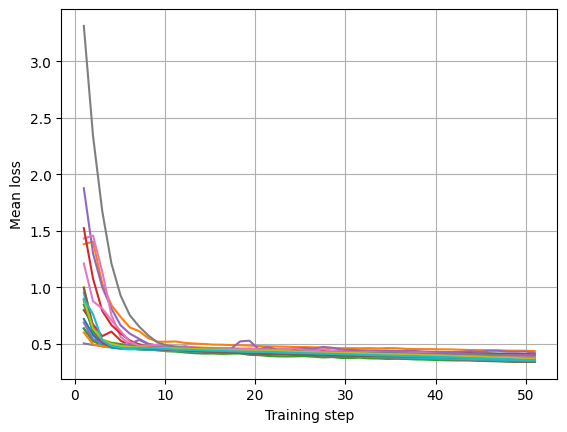

In [ ]:
tasks = training_loss.shape[0]
steps = training_loss.shape[1]

for i in range(tasks):
  plt.plot(np.linspace(1, steps+1, steps), training_loss[i,])
plt.xlabel('Training step')
plt.ylabel('Mean loss')
plt.grid()

In [ ]:
opt.optimizer.save('Optimizer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
opt = LearnableOptimizer()
temp = tf.keras.models.load_model('Optimizer.h5')
opt.optimizer.set_weights(temp.get_weights())

In [ ]:
epochs = 1000

# Train PINN using the learnable optimizer
model = build_neural_network()

# Clone model before training to exactly compare optimizers
model_ = build_neural_network()
model_.set_weights(model.get_weights())

In [ ]:
# Use optimizer on linear advection
loss = opt.train_model(data, model, eqn='la', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0149, 0.4948
PDE loss, IV loss in 100th epoch: 0.0805, 0.0449
PDE loss, IV loss in 200th epoch: 0.0667, 0.0229
PDE loss, IV loss in 300th epoch: 0.0569, 0.0070
PDE loss, IV loss in 400th epoch: 0.0519, 0.0066
PDE loss, IV loss in 500th epoch: 0.0447, 0.0077
PDE loss, IV loss in 600th epoch: 0.0379, 0.0032
PDE loss, IV loss in 700th epoch: 0.0292, 0.0031
PDE loss, IV loss in 800th epoch: 0.0175, 0.0010
PDE loss, IV loss in 900th epoch: 0.0053, 0.0001


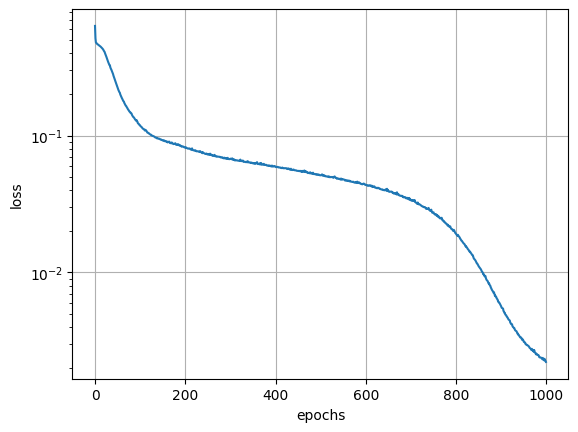

In [ ]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

In [ ]:
# Train PINN using the regular Adam optimizer
opt2 = AdamOptimizer()
loss_ = opt2.train_model(data, model_, eqn='la', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0363, 0.5191
PDE loss, IV loss in 100th epoch: 0.1056, 0.1876
PDE loss, IV loss in 200th epoch: 0.0810, 0.0502
PDE loss, IV loss in 300th epoch: 0.0792, 0.0146
PDE loss, IV loss in 400th epoch: 0.0681, 0.0119
PDE loss, IV loss in 500th epoch: 0.0648, 0.0136
PDE loss, IV loss in 600th epoch: 0.0602, 0.0087
PDE loss, IV loss in 700th epoch: 0.0532, 0.0077
PDE loss, IV loss in 800th epoch: 0.0515, 0.0068
PDE loss, IV loss in 900th epoch: 0.0449, 0.0050


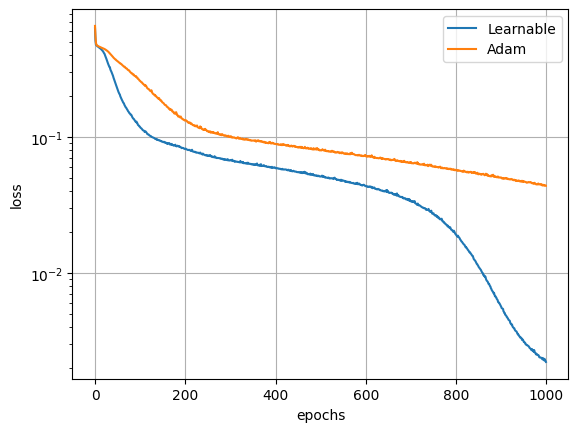

In [ ]:
# loss = np.load('lossLA.npy')
# loss_ = np.load('lossLA_.npy')

plt.semilogy(range(0, epochs), loss)
plt.semilogy(range(0, epochs), loss_)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Learnable','Adam'])
plt.grid()

fname = 'Comparison_tasks' + str(tasks) + '_cycles' + str(cycles) + '_steps' + str(steps) + \
        'K_' + str(K) + 'N_' + str(N) + 'sigma_' + str(sigma) + '_alpha' + str(alpha) +\
        'wd_' + str(wd) + '.png'
plt.savefig(fname)

In [ ]:
# Grid where to evaluate the model
l, m = 100, 200
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
T, X = np.meshgrid(t, x, indexing='ij')

u = model([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u = np.reshape(u, (l, m))


u_ = model_([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u_ = np.reshape(u_, (l, m))

In [ ]:
ureference = u0(X - T)

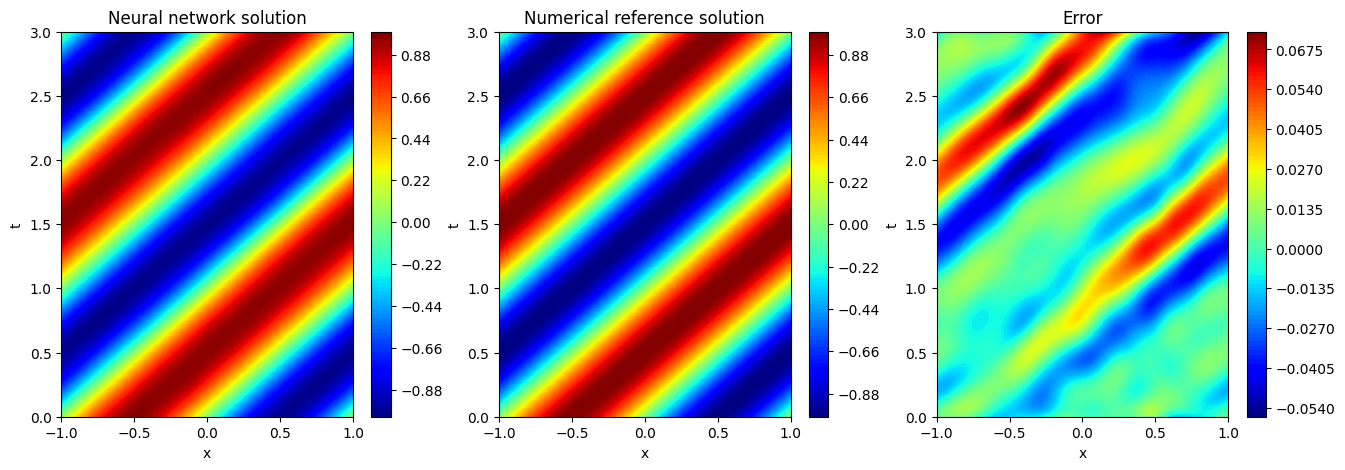

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('Learnable.png')

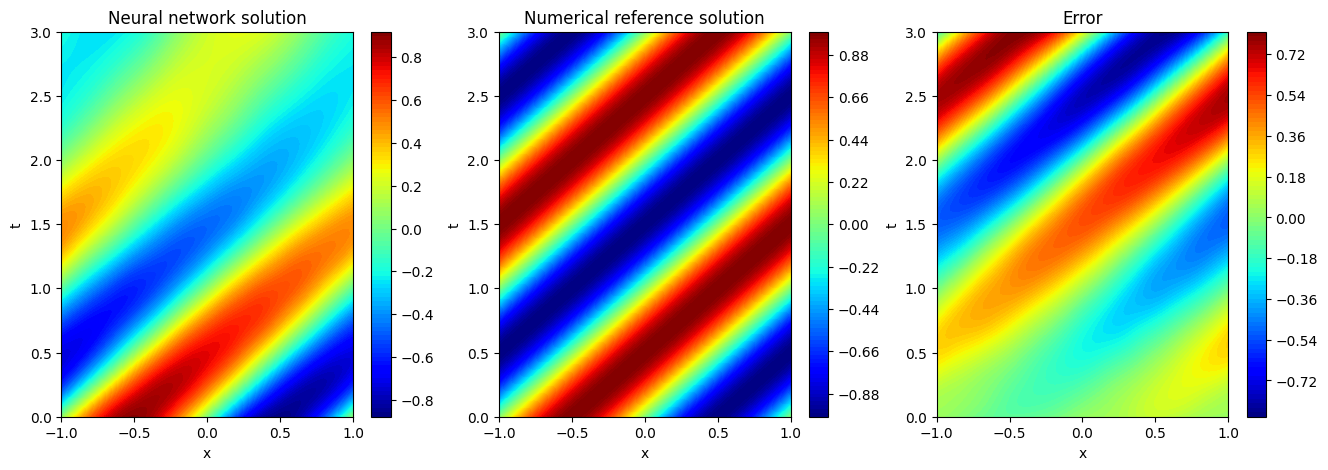

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u_, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u_-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('Adam.png')

In [ ]:
# Save the models
model.save('LearnableLA.h5')
model_.save('AdamLA.h5')
np.save('lossLA.npy', loss)
np.save('lossLA_.npy', loss_)

In [ ]:
print(f'Total l1 error LA learnable: {np.mean(np.abs(u-ureference))}')
print(f'Total l1 error LA Adam: {np.mean(np.abs(u_-ureference))}')

print(f'Total l2 error LA learnable: {np.mean((u-ureference)**2)}')
print(f'Total l2 error LA Adam: {np.mean((u_-ureference)**2)}')

Total l1 error LA learnable: 0.01820036308630098
Total l1 error LA Adam: 0.3252602241023688
Total l2 error LA learnable: 0.0005934685749135779
Total l2 error LA Adam: 0.1574205371292919


### Now use on KdV

In [ ]:
# Reload the optimizer
opt = LearnableOptimizer()
temp = tf.keras.models.load_model('Optimizer.h5')
opt.optimizer.set_weights(temp.get_weights())

In [ ]:
t0, tfinal = 0.0, 1.0

u0 = lambda x: np.cos(np.pi*x)
c = -0.0025

In [ ]:
# Parameters of the problem
data = {'t_bdry': [t0, tfinal],
        'x_bdry': [xleft, xright],
        'u0': u0}

In [ ]:
# Train PINN using the learnable optimizer
epochs = 1000

modelKdV = build_neural_network()

# Clone model before training to exactly compare optimizers
modelKdV_ = build_neural_network()
modelKdV_.set_weights(modelKdV.get_weights())

In [ ]:
# Use optimizer on linear advection
lossKdV = opt.train_model(data, modelKdV, eqn='kdv', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0769, 0.1702
PDE loss, IV loss in 100th epoch: 0.0495, 0.0579
PDE loss, IV loss in 200th epoch: 0.0494, 0.0503
PDE loss, IV loss in 300th epoch: 0.0383, 0.0348
PDE loss, IV loss in 400th epoch: 0.0239, 0.0498
PDE loss, IV loss in 500th epoch: 0.0227, 0.0248
PDE loss, IV loss in 600th epoch: 0.0181, 0.0248
PDE loss, IV loss in 700th epoch: 0.0157, 0.0203
PDE loss, IV loss in 800th epoch: 0.0106, 0.0167
PDE loss, IV loss in 900th epoch: 0.0091, 0.0082


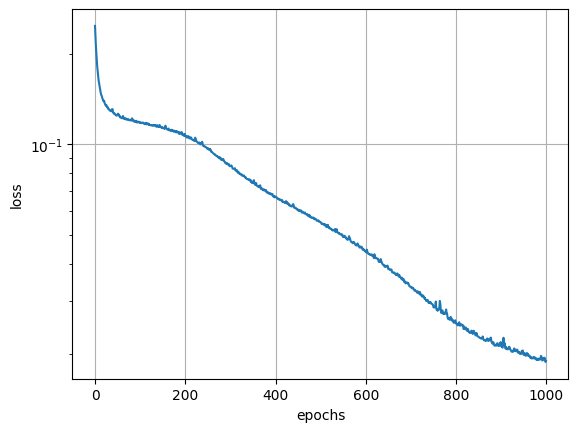

In [ ]:
plt.semilogy(range(0, epochs), lossKdV)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

In [ ]:
# Train PINN using the regular Adam optimizer
opt2 = AdamOptimizer()
lossKdV_ = opt2.train_model(data, modelKdV_, eqn='kdv', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0775, 0.0978
PDE loss, IV loss in 100th epoch: 0.0528, 0.0987
PDE loss, IV loss in 200th epoch: 0.0457, 0.0607
PDE loss, IV loss in 300th epoch: 0.0414, 0.0955
PDE loss, IV loss in 400th epoch: 0.0400, 0.0630
PDE loss, IV loss in 500th epoch: 0.0300, 0.0686
PDE loss, IV loss in 600th epoch: 0.0289, 0.0352
PDE loss, IV loss in 700th epoch: 0.0216, 0.0236
PDE loss, IV loss in 800th epoch: 0.0232, 0.0219
PDE loss, IV loss in 900th epoch: 0.0214, 0.0331


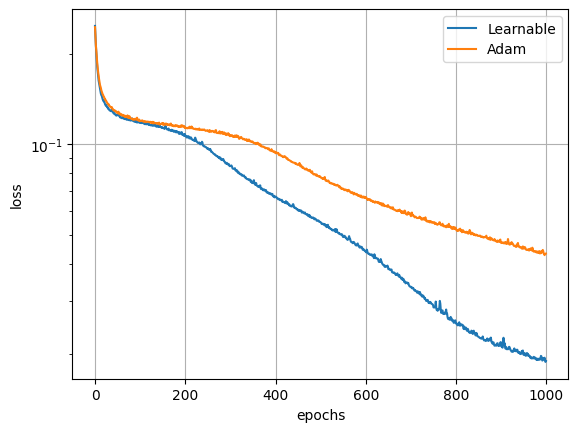

In [ ]:
# lossKdV = np.load('lossKdV.npy')
# lossKdV_ = np.load('lossKdV_.npy')

plt.semilogy(range(0, epochs), lossKdV)
plt.semilogy(range(0, epochs), lossKdV_)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Learnable','Adam'])
plt.grid()

fname = 'Comparison_tasks' + str(tasks) + '_cycles' + str(cycles) + '_steps' + str(steps) + \
        'K_' + str(K) + 'N_' + str(N) + 'sigma_' + str(sigma) + '_alpha' + str(alpha) +\
        'wd_' + str(wd) + '.png'
plt.savefig(fname)

In [ ]:
# Grid where to evaluate the model
l, m = 100, 200
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
T, X = np.meshgrid(t, x, indexing='ij')

u = modelKdV([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u = np.reshape(u, (l, m))


u_ = modelKdV_([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u_ = np.reshape(u_, (l, m))

In [ ]:
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff

L = xright - xleft
xx = np.linspace(xleft, xright, m)
tt = np.linspace(t0, tfinal, l*20)

# Numerical reference solution for the KdV equation
def kdv(u, t, L):
  ux = psdiff(u, period=L)
  uxxx = psdiff(u, period=L, order=3)
  ut = -u*ux + c*uxxx
  return ut

def solve_kdv(u0, t, L):
  sol = odeint(kdv, u0, t, args=(L,))
  return sol

ureference = solve_kdv(u0(xx), tt, L)
ureference = ureference[::20,]

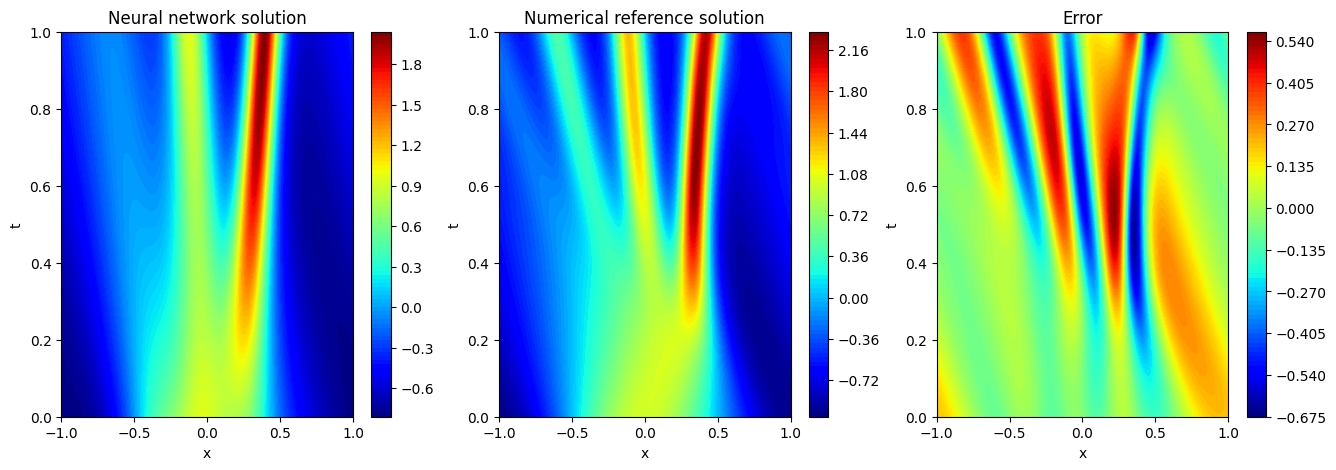

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('LearnableKdV.png')

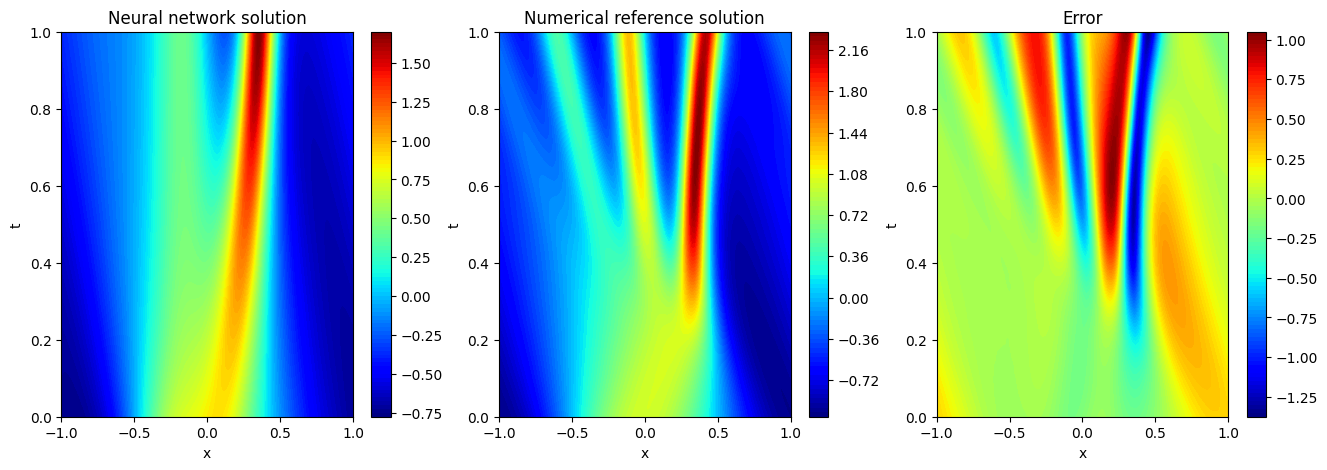

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u_, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u_-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('AdamKdV.png')

In [ ]:
# Save the models
modelKdV.save('LearnableKdV.h5')
modelKdV_.save('AdamKdV.h5')
np.save('lossKdV.npy', lossKdV)
np.save('lossKdV_.npy', lossKdV_)

In [ ]:
print(f'Total l1 error KdV learnable: {np.mean(np.abs(u-ureference))}')
print(f'Total l1 error KdV Adam: {np.mean(np.abs(u_-ureference))}')

print(f'Total l2 error KdV learnable: {np.mean((u-ureference)**2)}')
print(f'Total l2 error KdV Adam: {np.mean((u_-ureference)**2)}')

Total l1 error KdV learnable: 0.15726561306265202
Total l1 error KdV Adam: 0.24606969706041074
Total l2 error KdV learnable: 0.04549642586635675
Total l2 error KdV Adam: 0.1376940448606415


### Now use on Burgers

In [ ]:
# Reload the optimizer
opt = LearnableOptimizer()
temp = tf.keras.models.load_model('Optimizer.h5')
opt.optimizer.set_weights(temp.get_weights())

In [ ]:
# Boundaries of the computational domain
xleft, xright = -1, 1
t0, tfinal = 0, 1.0

In [ ]:
u0 = lambda x: -np.sin(np.pi*x)
c = -0.01/np.pi

In [ ]:
# Parameters of the problem
data = {'t_bdry': [t0, tfinal],
        'x_bdry': [xleft, xright],
        'u0': u0}

In [ ]:
# Train PINN using the learnable optimizer
epochs = 1000

modelBurgers = build_neural_network()

# Clone model before training to exactly compare optimizers
modelBurgers_ = build_neural_network()
modelBurgers_.set_weights(modelBurgers.get_weights())

In [ ]:
# Use optimizer on linear advection
lossBurgers = opt.train_model(data, modelBurgers, eqn='burgers', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0700, 0.1165
PDE loss, IV loss in 100th epoch: 0.0456, 0.0673
PDE loss, IV loss in 200th epoch: 0.0332, 0.0875
PDE loss, IV loss in 300th epoch: 0.0316, 0.0431
PDE loss, IV loss in 400th epoch: 0.0391, 0.0451
PDE loss, IV loss in 500th epoch: 0.0319, 0.0254
PDE loss, IV loss in 600th epoch: 0.0217, 0.0316
PDE loss, IV loss in 700th epoch: 0.0131, 0.0212
PDE loss, IV loss in 800th epoch: 0.0103, 0.0091
PDE loss, IV loss in 900th epoch: 0.0081, 0.0038


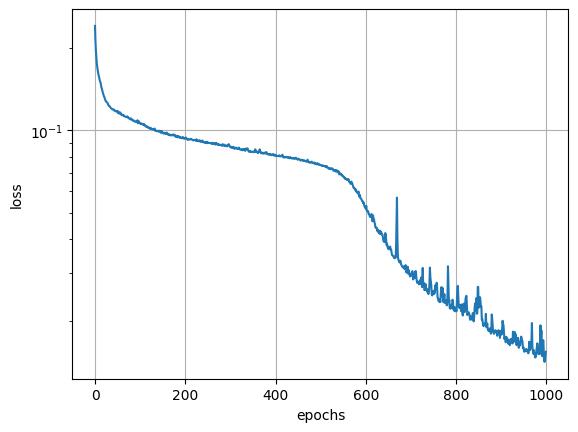

In [ ]:
plt.semilogy(range(0, epochs), lossBurgers)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

In [ ]:
# Train PINN using the regular Adam optimizer
opt2 = AdamOptimizer()
lossBurgers_ = opt2.train_model(data, modelBurgers_, eqn='burgers', epochs=epochs)

PDE loss, IV loss in 0th epoch: 0.0687, 0.1811
PDE loss, IV loss in 100th epoch: 0.0531, 0.0596
PDE loss, IV loss in 200th epoch: 0.0358, 0.0852
PDE loss, IV loss in 300th epoch: 0.0334, 0.0414
PDE loss, IV loss in 400th epoch: 0.0331, 0.0622
PDE loss, IV loss in 500th epoch: 0.0289, 0.0566
PDE loss, IV loss in 600th epoch: 0.0355, 0.0398
PDE loss, IV loss in 700th epoch: 0.0119, 0.0187
PDE loss, IV loss in 800th epoch: 0.0140, 0.0185
PDE loss, IV loss in 900th epoch: 0.0103, 0.0152


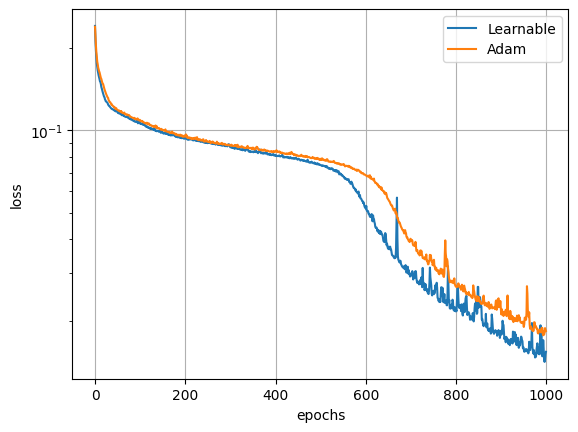

In [ ]:
# lossBurgers = np.load('lossBurgers.npy')
# lossBurgers_ = np.load('lossBurgers_.npy')

plt.semilogy(range(0, epochs), lossBurgers)
plt.semilogy(range(0, epochs), lossBurgers_)

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Learnable','Adam'])
plt.grid()

fname = 'Comparison_tasks' + str(tasks) + '_cycles' + str(cycles) + '_steps' + str(steps) + \
        'K_' + str(K) + 'N_' + str(N) + 'sigma_' + str(sigma) + '_alpha' + str(alpha) +\
        'wd_' + str(wd) + '.png'
plt.savefig(fname)

In [ ]:
# Grid where to evaluate the model
l, m = 100, 500
t = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
T, X = np.meshgrid(t, x, indexing='ij')

u = modelBurgers([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u = np.reshape(u, (l, m))


u_ = modelBurgers_([np.expand_dims(T.flatten(), axis=1),
           np.expand_dims(X.flatten(), axis=1)])
u_ = np.reshape(u_, (l, m))

In [ ]:
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff

L = xright - xleft
xx = np.linspace(xleft, xright, m)
tt = np.linspace(t0, tfinal, l)

# Numerical reference solution for the KdV equation
def burgers(u, t, L):
  ux = psdiff(u, period=L)
  uxx = psdiff(u, period=L, order=2)
  ut = -u*ux - c*uxx
  return ut

def solve_burgers(u0, t, L):
  sol = odeint(burgers, u0, t, args=(L,))
  return sol

ureference = solve_burgers(u0(xx), tt, L)
ureference = ureference[:,]

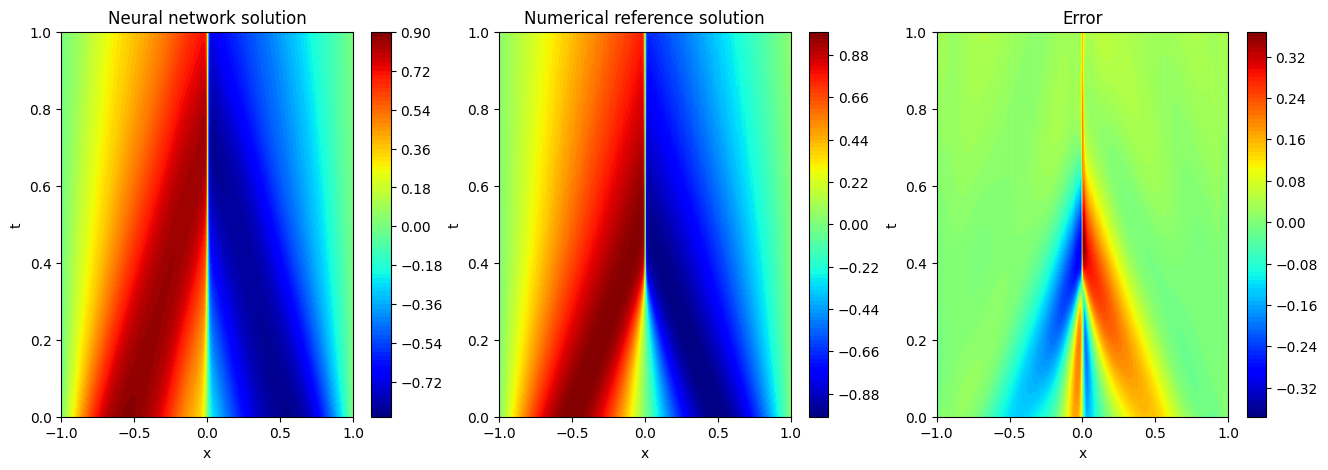

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('LearnableBurgers.png')

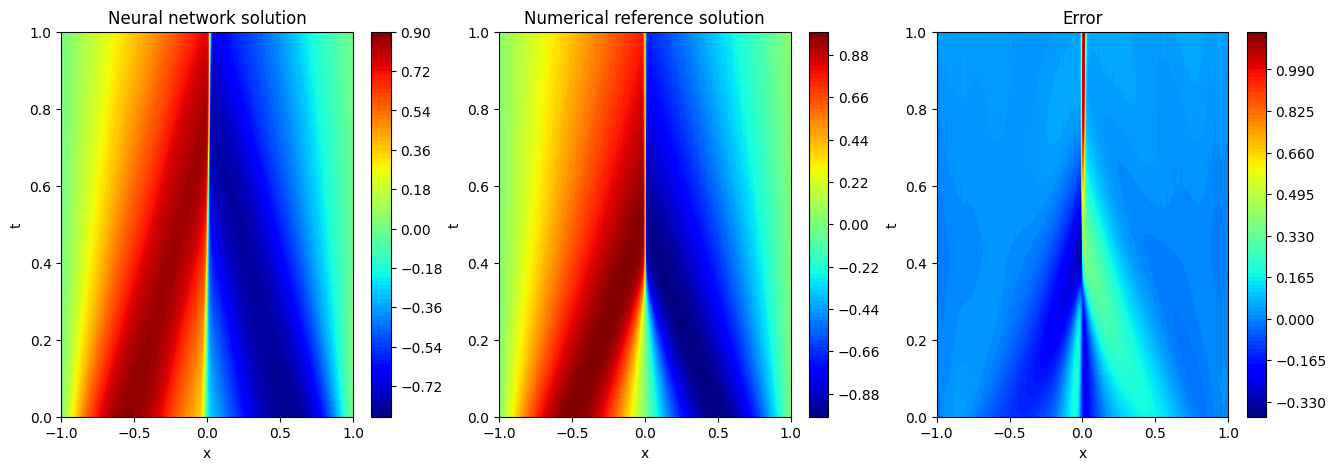

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.contourf(X, T, u_, 100, cmap=plt.cm.jet)
plt.title('Neural network solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(132)
plt.contourf(X, T, ureference, 100, cmap=plt.cm.jet)
plt.title('Numerical reference solution')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.subplot(133)
plt.contourf(X, T, u_-ureference, 100, cmap=plt.cm.jet)
plt.title('Error')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()

plt.savefig('AdamBurgers.png')

In [ ]:
# Save the models
modelBurgers.save('LearnableBurgers.h5')
modelBurgers_.save('AdamBurgers.h5')
np.save('lossBurgers.npy', lossBurgers)
np.save('lossBurgers_.npy', lossBurgers_)

In [ ]:
print(f'Total l1 error Burgers learnable: {np.mean(np.abs(u-ureference))}')
print(f'Total l1 error Burgers Adam: {np.mean(np.abs(u_-ureference))}')

print(f'Total l2 error Burgers learnable: {np.mean((u-ureference)**2)}')
print(f'Total l2 error Burgers Adam: {np.mean((u_-ureference)**2)}')

Total l1 error Burgers learnable: 0.04578858313151542
Total l1 error Burgers Adam: 0.056133269973266335
Total l2 error Burgers learnable: 0.005582695828034749
Total l2 error Burgers Adam: 0.010372487771628776
